In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2 as cv, pandas as pd
from skimage.data import coins
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.color import lab2rgb
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.misc as misc
import skimage.filters
import scipy
from sklearn.decomposition import PCA
import copy
from tqdm import tqdm
%matplotlib inline

In [33]:
def show(self, cmap=None):
        cmap = cmap or plt.cm.gray
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(self, cmap=cmap)
        ax.set_axis_off()
        #plt.show()
        return fig
    
class Image(dict):
    def show(self, cmap=None):
        cmap = cmap or plt.cm.gray
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(self.array, cmap=cmap)
        ax.set_axis_off()
        #plt.show()
        return fig

    def preprocess(self):
        self.array = cv.cvtColor(self.array,cv.COLOR_BGR2GRAY)
        cv.imwrite('img001_otsu.png',self.array)
        t = threshold_otsu(self.array)
        self.img_bin = clear_border(closing(self.array > t, square(1)))
        self.labels = label(self.img_bin)
        #show(labels, cmap=plt.cm.rainbow)
        self.regions = regionprops(self.labels)
        #cv.imwrite('93_sobel_x_bin.png',img_bin)
        print(t)
        return self.img_bin, self.labels, self.regions

    def get_areas(self):
        rows = []
        n=0
        for region in self.regions:
            n += 1
            row = [n, region['BoundingBox'], region['Area']]
            rows.append(row)
        df = pd.DataFrame(rows,columns=['no','bounding_box','area'])
        df.sort_values('area',ascending=False,inplace=True)
        return df
    
    def get_border(self):
        df_15, df_4 = [pd.DataFrame(np.argwhere(self.labels==i), columns=['y','x'
                    ]) for i in [15,4]]
        df_15_left = df_15.groupby('y').min().reset_index()
        df_4_right = df_4.groupby('y').max().reset_index()
        df_concat = pd.concat([df_4_right, df_15_left])
        df_middle = df_concat.groupby('y').mean().reset_index()
        df_middle['x'] = df_middle['x'].apply(round)
        df_middle.to_csv('df_middle.csv',index=False)
        df_middle.plot(kind='scatter', x='x',y='y',xlim=(0,200))
        return df_middle    

    def plot_PCA(img):
        y, x = np.nonzero(self.array)
        x = x - np.mean(x)
        y = y - np.mean(y)
        coords = np.vstack([x, y])
        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        x_v2, y_v2 = evecs[:, sort_indices[1]]
        scale = -20
        plt.plot([0, x_v1*scale*2],
                 [0, y_v1*scale*2], color='red')
        plt.plot([0, x_v2*scale],
                 [0, y_v2*scale], color='blue')
        #plt.plot(x, y, 'k.')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()
        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.plot([0, x_v1*scale*2],
         [0, y_v1*scale*2], color='red')
        ax.plot([0, x_v2*scale],
                [0, y_v2*scale], color='blue')
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        return

    def get_arr_3D(self, threshold=25):
        y_size, x_size = self.array.shape
        self.arr_3D = np.zeros([y_size,x_size,int(self.array.max())+1])
        mask = self.array < threshold
        self.array[mask] = 0
        for i in range(y_size):
            for j in range(x_size):
                z = int(self.array[i,j])
                if z > 0:
                    self.arr_3D[i,j,z] = 1
        return self.arr_3D    

    def plot_PCA_3D(self):
        if 'arr_3D' not in self.__dict__.keys():
            self.get_arr_3D()
        y, x, z = np.nonzero(self.arr_3D)
        x_m, y_m, z_m = [np.mean(i) for i in [x,y,z]]
        x = x - np.mean(x)
        y = y - np.mean(y)
        z = z - np.mean(z)
        coords = np.vstack([x, y, z])
        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        x_v1, y_v1, z_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        x_v2, y_v2, z_v1 = evecs[:, sort_indices[1]]
        # ktory ma wieksze wartosci w x,y
        #sprawdzic czy nie idzie za bardzo w z!
        scale = 20
        #plt.plot([x_m, x_m + x_v1*scale*2],
        #     [y_m,y_m + y_v1*scale*2], color='red')
        #plt.plot([x_m, x_m + x_v2*scale],
        #     [y_m, y_m + y_v2*scale], color='blue')
        #plt.plot(x, y, 'k.')
        #plt.axis('equal')
        #plt.gca().invert_yaxis()  # Match the image system with origin at top left
        #plt.show()
        fig, ax = plt.subplots(1,1)
        #x = range(300)
        ax.imshow(self.array)
        ax.plot([x_m +0, x_m +x_v1*scale*2], [y_m +0, y_m +y_v1*scale*2], color='red')
        ax.plot([x_m - x_v2*scale, x_m + x_v2*scale], [y_m - y_v2*scale, y_m +y_v2*scale], color='blue')
        ax.plot([x_m + y_v2*scale*0.5, x_m - y_v2*scale*0.5], [y_m - x_v2*scale*0.5, y_m +x_v2*scale*0.5], color='green')
        #ax.plot([x_m +0, x_m +x_v1*scale*2], [y_m +0, y_m +y_v1*scale*2], color='red')
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        self.vec = [x_v1, y_v1]
        self.a = y_v1/x_v1
        return [[x_v1, y_v1], [x_v2, y_v2]]

    def plot_3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        y,x,z = np.nonzero(self.arr_3D)
        #z = (np.ones(np.size(u)),
        ax.scatter(x, y, z,marker='^',c=z, cmap=plt.cm.autumn)
        #ax.plot_surface(x, y, z, color='b')
        ax.set_xlabel('x')
        return fig

    def calc_dev(self, epsilon=0):
        mask = self.array < 10
        self.array[mask] = 0
        y, x = np.nonzero(self.array)
        x_m, y_m, z_m = [np.mean(i) for i in [x,y,z]]
        #epsilon = 0
        #arr_3D y_m
        y_window = 5
        x_pos = int(round(x_m)) + epsilon
        y_m_i = int(round(y_m))
        left_points = self.array[y_m_i-y_window:y_m_i+y_window, 0:x_pos]
        y,x = np.nonzero(left_points)
        sum_diff = 0.0
        for i in range(y.shape[0]):
            diff = self.array[y[i],x[i]] - self.array[y[i], x_pos + x_pos - x[i]] 
            sum_diff += diff**2
        sum_diff = (sum_diff)**(0.5)/y.shape[0]
        return sum_diff
    
    def get_slice(self, dist = 5, y_m = None):
        self.a_p = -self.vec[0]/self.vec[1]
        y, x = np.nonzero(self.array)
        if y_m is None:
            y_m = np.mean(y)
        x_m = self.array.shape[1]/2
        #[x_m, y_m] + 
        ang = np.arctan2(self.vec[0],self.vec[1])*360/(2*np.pi)
        self.b_p_m = y_m - (self.a_p*x_m)
        self.b_m = y_m - (self.a*x_m)
        y_dist = dist /np.cos(ang)
        b_up = self.b_p_m + y_dist
        b_down = self.b_p_m - y_dist
        print(b_up, b_down)
        if b_up < b_down:
            b_up, b_down = [i for i in [ b_down, b_up]]
        slice_i = copy.deepcopy(self)
        for y in range(self.array.shape[0]):
            for x in range(self.array.shape[1]):
                if (y > (self.a_p*x) + b_up) or (y < (self.a_p*x) + b_down):
                    slice_i.array[y,x] = 0
        return slice_i

    def calc_dev_slice(self, epsilon =0):
        b = self.b_m + epsilon
        a = self.a
        mask = self.array < 100
        self.array[mask] = 0
        left_points = copy.deepcopy(self.array)
        for y in range(self.array.shape[0]):
            for x in range(self.array.shape[1]):
                if x > ((y - b)/self.a):
                    left_points[y,x] = 0
        y, x = np.nonzero(left_points)
        sum_diff = 0.0
        oob = 0
        for i in range(y.shape[0]):
            x1 = x[i]
            y1 = y[i]
            #y = a*x + b
            d = (x1 + (y1 - b)*a)/(1 + a**2.0)
            x2 = int(round(2*d - x1))
            y2 = int(round(2*d*a - y1 + 2*b))
            #print(x2,y2)
            try:
                sum_diff += (self.array[y1,x1] - self.array[y2, x2])**2
            except IndexError:
                oob +=1
        div = y.shape[0] - oob
        sum_diff = (sum_diff)**(0.5)/(div*np.log(div))
        #fig, ax = plt.subplots(1,1)
        #ax.imshow(self.array)
        #ax.plot(xs, ys, color='red')
        return sum_diff

    def calc_devs_slice(self, epsilon_range=[0,40]):
        y, x = np.nonzero(self.array)
        devs = []
        epsilons = range(epsilon_range[0],epsilon_range[1])
        for eps in epsilons:
            devs.append(self.calc_dev_slice(epsilon=eps))
        epsval = epsilons[np.array(devs).argmin()]
        ys = np.linspace(np.min(y),np.max(y))
        xs = [((y_i - self.b_m -epsval)/self.a) for y_i in ys]
        fig, ax = plt.subplots(1,1)
        ax.imshow(self.array)
        ax.plot(xs, ys, color='red')        
        return 
        

    
    @classmethod
    def get(cls, path):
        i = cls()
        i.array = cv.imread(path)
        return i

    @classmethod
    def from_array(cls, array):
        i = cls()
        i.array = array
        return i
    
    def rotate(self,angle):
        self.array = scipy.ndimage.rotate(self.array,angle)
        return

In [10]:
img = Image.get('93_sobel_x.png')
img_bin, labels, regions = img.preprocess()
#img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
df = img.get_areas()
df.head(3)

88


,no,bounding_box,area
3,4,"(49, 1, 186, 23)",587
14,15,"(138, 13, 198, 32)",154
7,8,"(57, 17, 125, 28)",105


In [11]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
#edges = cv.Canny(img,100,200)

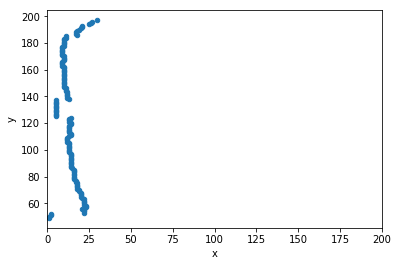

In [12]:
mask = labels == 8
labels[mask] = 15
#show(labels, cmap=plt.cm.viridis)
border = img.get_border()

In [13]:
from ipywidgets import widgets

@widgets.interact(t=(50, 240))
def threshold(t): 
    show(img.array > t)

interactive(children=(IntSlider(value=145, description='t', max=240, min=50), Output()), _dom_classes=('widget…

  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:204: RuntimeWarning: overflow encountered in ubyte_scalars


62.65183807826325 42.996762445631575


  1%|          | 1/94 [00:00<00:42,  2.20it/s]

59.881765365855 49.86514195330794


  2%|▏         | 2/94 [00:00<00:39,  2.35it/s]

69.71841196056987 44.24889830703733


  3%|▎         | 3/94 [00:01<00:39,  2.33it/s]

53.28136764323307 65.5414825717777


  4%|▍         | 4/94 [00:01<00:36,  2.49it/s]

47.683132214955094 77.2924210290618


  5%|▌         | 5/94 [00:02<00:36,  2.44it/s]

70.6873610362568 60.23717275646662


  6%|▋         | 6/94 [00:02<00:34,  2.52it/s]/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


7.670809820346925 130.4255553735815


  7%|▋         | 7/94 [00:03<00:48,  1.80it/s]

66.73677468061622 79.84508717496472


  9%|▊         | 8/94 [00:03<00:42,  2.03it/s]

84.04407099581039 73.70321011090829


 10%|▉         | 9/94 [00:03<00:37,  2.27it/s]

114.00005778934042 59.51322257959472


 11%|█         | 10/94 [00:04<00:41,  2.05it/s]

105.54215413048576 94.22450057856184


 12%|█▏        | 11/94 [00:04<00:36,  2.28it/s]

245.36277882444645 1.5089179500869534


 13%|█▎        | 12/94 [00:06<00:55,  1.47it/s]

163.7572765036866 185.63740067589416


 14%|█▍        | 13/94 [00:06<00:48,  1.68it/s]

389.5872630033358 440.1478869064033


 15%|█▍        | 14/94 [00:06<00:43,  1.84it/s]

-330.7115995281618 -341.79791641103265


 16%|█▌        | 15/94 [00:07<00:37,  2.11it/s]

-82.31741098394059 -59.99145717488611


 17%|█▋        | 16/94 [00:07<00:35,  2.22it/s]

4.7475850537918625 -46.23933465652057


 18%|█▊        | 17/94 [00:08<00:41,  1.85it/s]

-4.503461138404237 5.800888894505864


 19%|█▉        | 18/94 [00:08<00:37,  2.00it/s]

-29.116537947149755 53.21597506004272


 20%|██        | 19/94 [00:10<00:53,  1.39it/s]

-4.316131555899233 42.960610244380774


 21%|██▏       | 20/94 [00:11<00:58,  1.26it/s]

19.413607501956086 29.42000016681144


 22%|██▏       | 21/94 [00:11<00:49,  1.47it/s]

35.81545150832646 20.709256321477902


 23%|██▎       | 22/94 [00:11<00:44,  1.62it/s]

23.280138241888693 39.4315027191148


 24%|██▍       | 23/94 [00:12<00:41,  1.72it/s]

39.18576389761692 28.655580226470338


 26%|██▌       | 24/94 [00:12<00:38,  1.83it/s]

29.943190122377118 42.43590292587568


 27%|██▋       | 25/94 [00:13<00:35,  1.92it/s]

20.135326951689812 56.40724874678799


 28%|██▊       | 26/94 [00:14<00:40,  1.69it/s]

45.253921930298674 35.109214323773855


 29%|██▊       | 27/94 [00:14<00:36,  1.83it/s]

58.13852459415517 25.72996951642203


 30%|██▉       | 28/94 [00:15<00:38,  1.72it/s]

37.38388805512453 49.77925196041582


 31%|███       | 29/94 [00:15<00:35,  1.84it/s]

39.641194421196566 50.59113190801836


 32%|███▏      | 30/94 [00:16<00:32,  1.96it/s]

30.992720071560157 62.06596669177186


 33%|███▎      | 31/94 [00:16<00:34,  1.83it/s]

61.93136954423672 33.81402376022442


 34%|███▍      | 32/94 [00:17<00:34,  1.81it/s]

55.280984014855854 43.04919833946081


 35%|███▌      | 33/94 [00:17<00:30,  2.00it/s]

55.50439899362404 45.48560703679581


 36%|███▌      | 34/94 [00:18<00:27,  2.16it/s]

59.142248446268376 44.57746640907917


 37%|███▋      | 35/94 [00:18<00:26,  2.24it/s]

-1323.3852053849757 1429.8357473924627


 38%|███▊      | 36/94 [00:19<00:44,  1.29it/s]

48.43696810394605 60.897280819646774


 39%|███▉      | 37/94 [00:20<00:36,  1.55it/s]

50.852704199810105 61.385860775677216


 40%|████      | 38/94 [00:20<00:30,  1.84it/s]

41.84329558167544 73.26205196094558


 41%|████▏     | 39/94 [00:21<00:28,  1.93it/s]

67.18240463774423 50.83300959088495


 43%|████▎     | 40/94 [00:21<00:26,  2.02it/s]

65.5733989549802 55.433388313692845


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: invalid value encountered in double_scalars
 44%|████▎     | 41/94 [00:21<00:23,  2.29it/s]

76.00111728081691 47.95331693451282


 45%|████▍     | 42/94 [00:22<00:21,  2.38it/s]

57.26946843518977 69.84551307314294


 46%|████▌     | 43/94 [00:22<00:19,  2.67it/s]

51.94600203957108 78.81744242194814


 47%|████▋     | 44/94 [00:22<00:18,  2.75it/s]

73.23134636616254 61.72063075129591


 48%|████▊     | 45/94 [00:23<00:16,  2.98it/s]

-98.40155115902084 238.24446580799915


 49%|████▉     | 46/94 [00:24<00:31,  1.53it/s]

67.40393686667745 78.89034075293792


 50%|█████     | 47/94 [00:24<00:25,  1.87it/s]

120.69212811254359 35.12900521646223


 51%|█████     | 48/94 [00:25<00:30,  1.52it/s]

69.3806907079066 104.09094208814118


 52%|█████▏    | 49/94 [00:26<00:26,  1.69it/s]

100.06158649788884 131.3546017872829


 53%|█████▎    | 50/94 [00:26<00:25,  1.73it/s]

-154.71353206195087 -202.51159982309653


 54%|█████▍    | 51/94 [00:27<00:22,  1.95it/s]

49.34528798453441 10.906359815113959


 55%|█████▌    | 52/94 [00:27<00:20,  2.03it/s]

31.4708978047122 65.09778593253728


 56%|█████▋    | 53/94 [00:27<00:18,  2.21it/s]

7.880650729521818 102.76008393468572


 57%|█████▋    | 54/94 [00:28<00:26,  1.52it/s]

48.34497829088478 70.07317080789427


 59%|█████▊    | 55/94 [00:29<00:22,  1.74it/s]

71.40519107428936 53.307306087057654


 60%|█████▉    | 56/94 [00:29<00:18,  2.06it/s]

59.80036537306544 69.80643707586475


 61%|██████    | 57/94 [00:29<00:15,  2.37it/s]

41.48659398573032 91.81081474978681


 62%|██████▏   | 58/94 [00:30<00:16,  2.12it/s]

79.71523559748795 56.37736159995407


 63%|██████▎   | 59/94 [00:30<00:15,  2.32it/s]

78.31990929811181 59.93490011323821


 64%|██████▍   | 60/94 [00:31<00:15,  2.25it/s]

80.5625547623529 59.596786659921776


 65%|██████▍   | 61/94 [00:31<00:13,  2.42it/s]

127.96404544783852 13.69061630222344


 66%|██████▌   | 62/94 [00:33<00:23,  1.37it/s]

63.09265455440937 79.64272888904941


 67%|██████▋   | 63/94 [00:33<00:19,  1.63it/s]

66.8208480152984 76.87695794077118


 68%|██████▊   | 64/94 [00:33<00:15,  1.91it/s]

65.76671904701249 78.88211121967902


 69%|██████▉   | 65/94 [00:34<00:13,  2.14it/s]

105.70641457135079 39.591596396549456


 70%|███████   | 66/94 [00:34<00:15,  1.78it/s]

77.93917659651211 67.71150094068923


 71%|███████▏  | 67/94 [00:35<00:13,  2.04it/s]

98.36821504679634 47.03577074339651


 72%|███████▏  | 68/94 [00:35<00:14,  1.85it/s]

67.30622002443033 77.34270159405338


 73%|███████▎  | 69/94 [00:36<00:12,  2.06it/s]

80.75740906618167 62.62397677160054


 74%|███████▍  | 70/94 [00:36<00:10,  2.19it/s]

87.07828022677208 54.49911833128235


 76%|███████▌  | 71/94 [00:37<00:10,  2.11it/s]

63.82724423399265 75.33574111361342


 77%|███████▋  | 72/94 [00:37<00:09,  2.29it/s]

72.93078094219254 62.930598483329184


 78%|███████▊  | 73/94 [00:37<00:08,  2.44it/s]

60.460371564877455 70.93129290167182


 79%|███████▊  | 74/94 [00:38<00:07,  2.59it/s]

69.26811701169606 56.844843919294206


 80%|███████▉  | 75/94 [00:38<00:07,  2.61it/s]

51.55672164476917 67.96530804231753


 81%|████████  | 76/94 [00:38<00:07,  2.57it/s]

53.21738787521672 68.0243647283944


 82%|████████▏ | 77/94 [00:39<00:06,  2.57it/s]

54.85774573192463 67.97213013941597


 83%|████████▎ | 78/94 [00:39<00:06,  2.56it/s]

56.46972211132234 66.66251235562866


 84%|████████▍ | 79/94 [00:40<00:05,  2.61it/s]

66.1148676578532 55.869133426995944


 85%|████████▌ | 80/94 [00:40<00:05,  2.66it/s]

73.41786404211646 45.22420799737172


 86%|████████▌ | 81/94 [00:40<00:05,  2.33it/s]

51.206999719309785 61.21202018376872


 87%|████████▋ | 82/94 [00:41<00:04,  2.47it/s]

42.62046465338915 66.62993813124456


 88%|████████▊ | 83/94 [00:41<00:04,  2.32it/s]

120.22573299379476 -11.47485455792031


 89%|████████▉ | 84/94 [00:43<00:06,  1.49it/s]

74.61748033409454 35.21701779283609


 90%|█████████ | 85/94 [00:43<00:06,  1.39it/s]

49.193283398338565 65.20248703051904


 91%|█████████▏| 86/94 [00:44<00:05,  1.57it/s]

50.82647344833685 60.832264965895455


 93%|█████████▎| 87/94 [00:44<00:03,  1.80it/s]

-52.753308110082216 135.664096317847


 94%|█████████▎| 88/94 [00:46<00:05,  1.19it/s]

-10.993752619890703 -0.3969144805726863


 95%|█████████▍| 89/94 [00:46<00:03,  1.43it/s]

-47.62023111468214 -57.751387850154586


 96%|█████████▌| 90/94 [00:46<00:02,  1.70it/s]

-167.76121165630335 -157.74759522520148


 97%|█████████▋| 91/94 [00:47<00:01,  1.99it/s]

-659.6289146791228 -669.8400343820995


 98%|█████████▊| 92/94 [00:47<00:00,  2.31it/s]

1193.4520706641918 1203.697133946224


 99%|█████████▉| 93/94 [00:47<00:00,  2.59it/s]

466.05382942871995 456.0310422763305


100%|██████████| 94/94 [00:48<00:00,  2.74it/s]


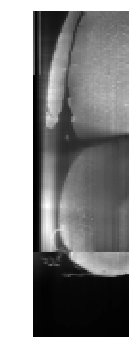

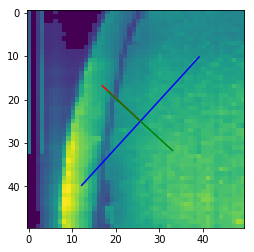

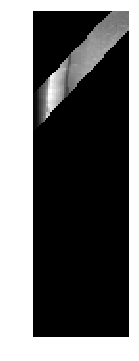

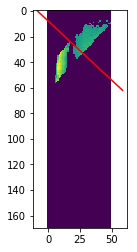

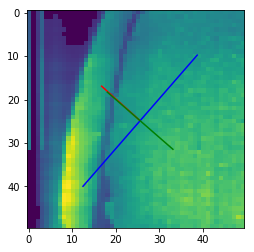

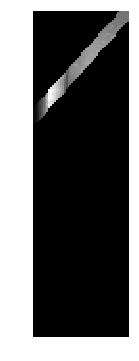

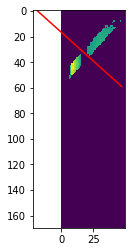

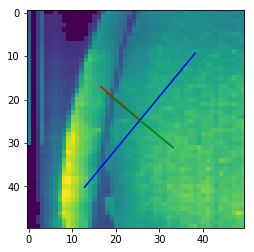

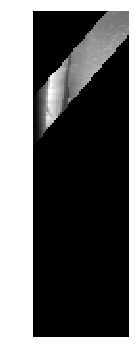

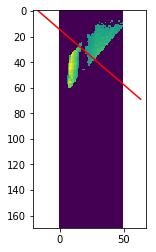

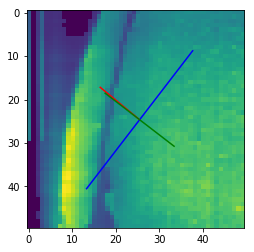

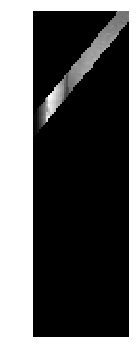

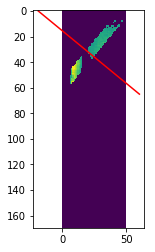

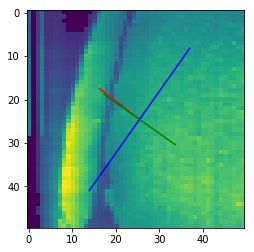

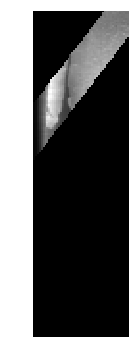

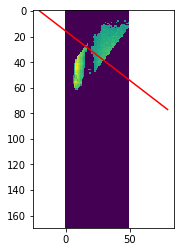

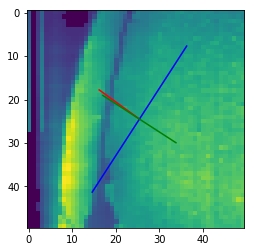

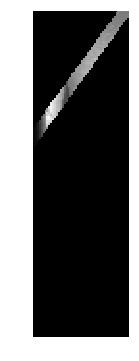

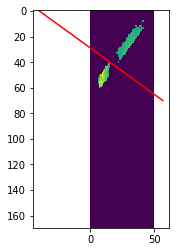

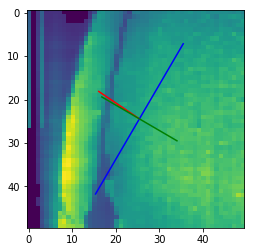

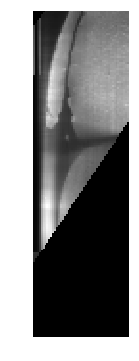

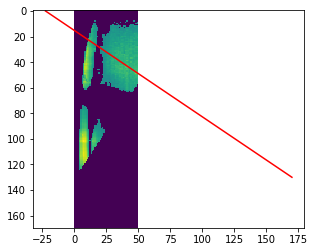

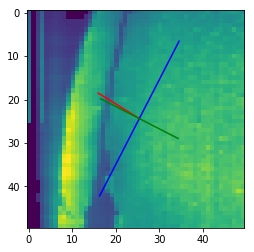

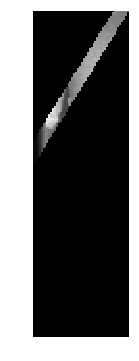

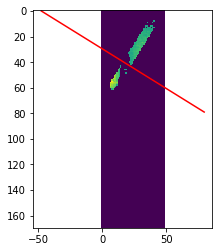

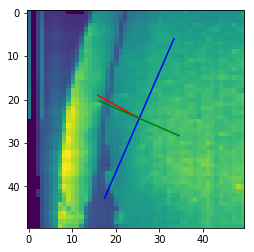

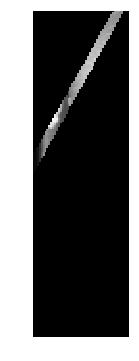

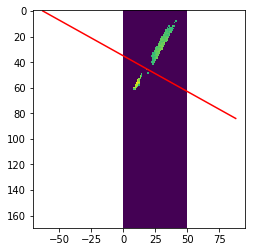

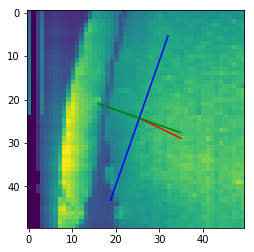

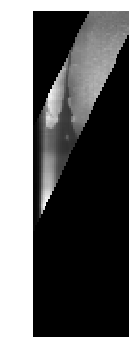

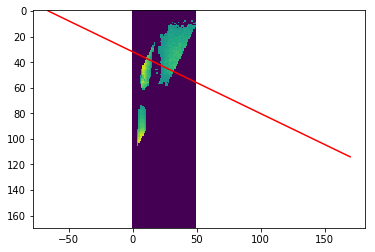

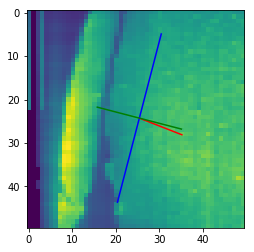

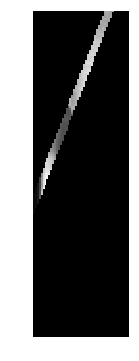

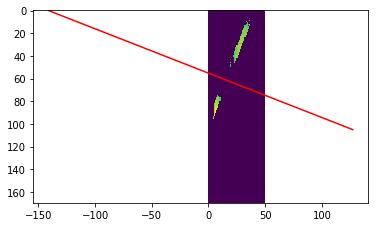

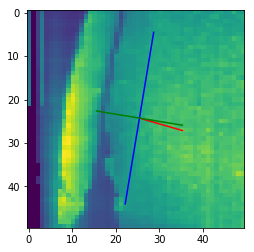

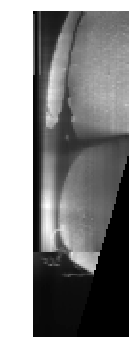

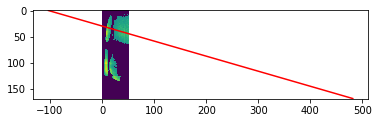

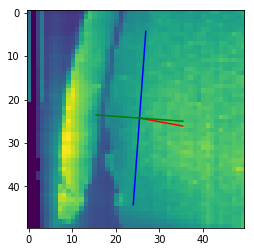

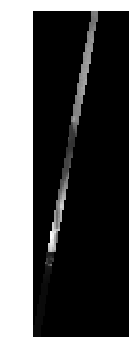

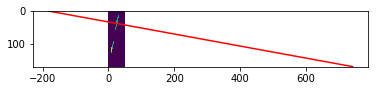

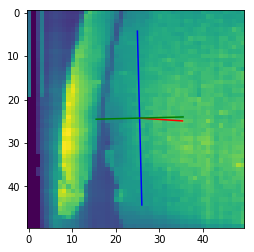

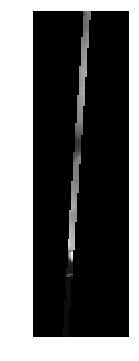

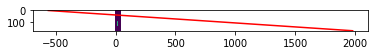

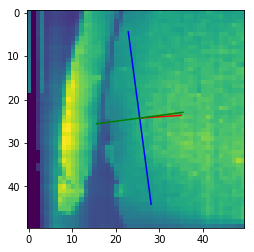

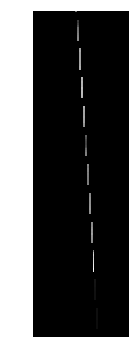

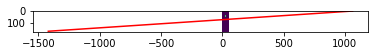

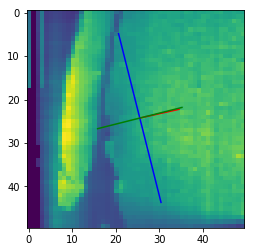

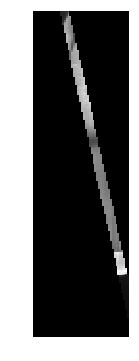

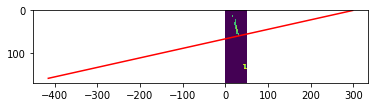

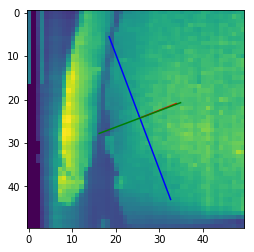

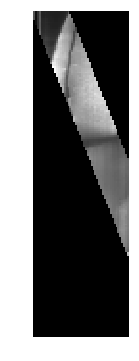

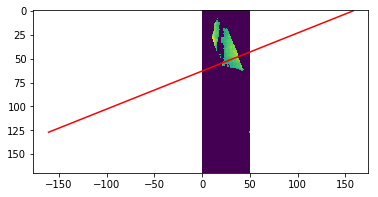

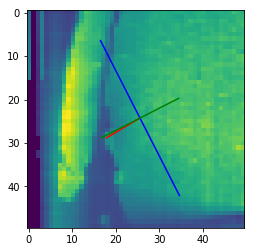

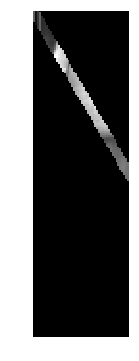

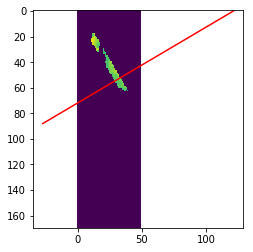

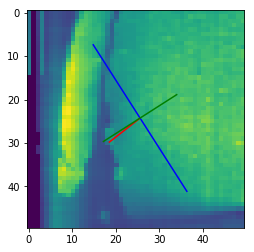

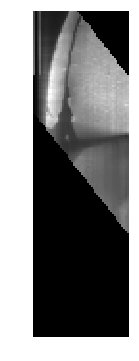

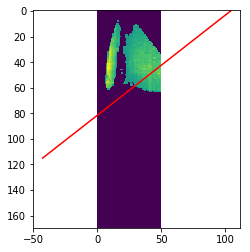

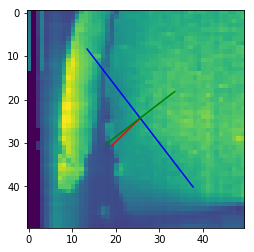

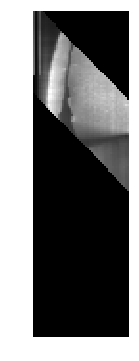

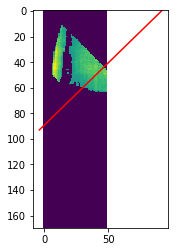

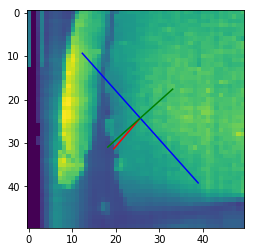

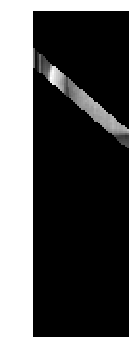

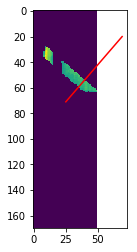

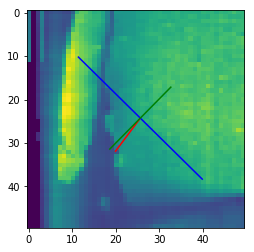

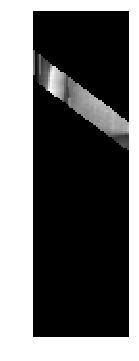

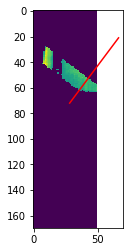

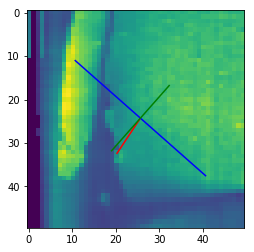

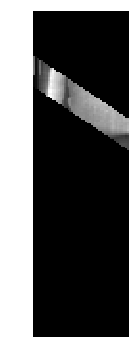

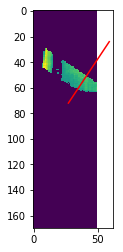

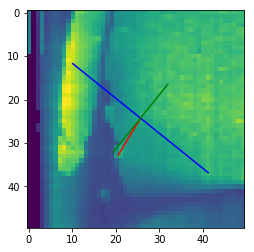

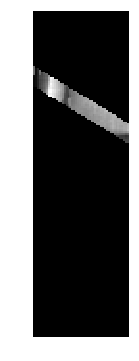

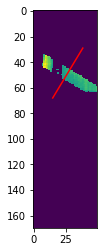

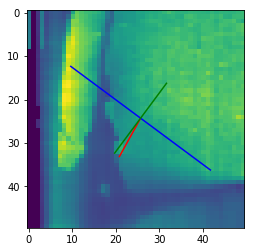

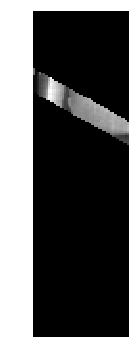

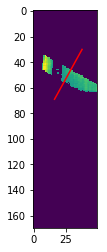

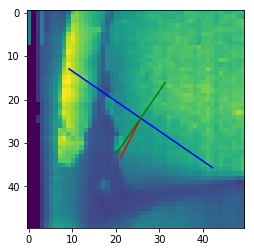

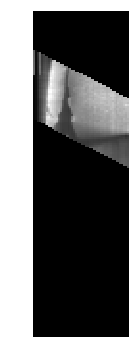

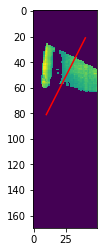

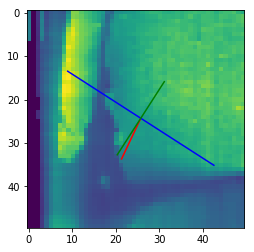

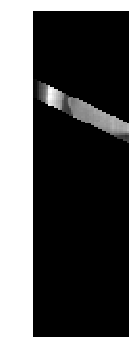

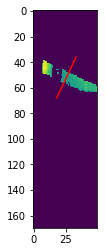

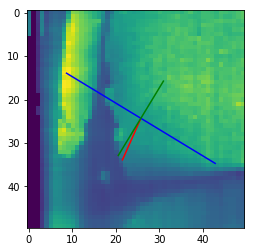

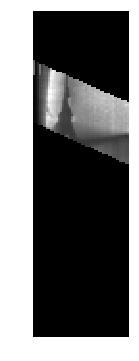

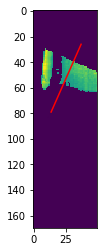

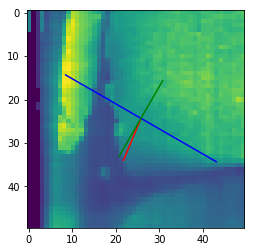

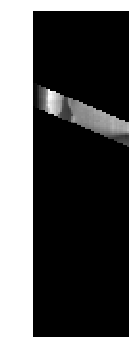

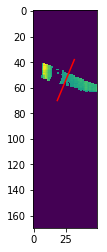

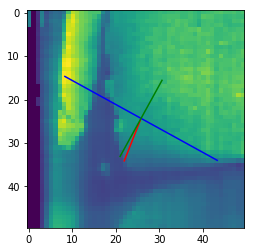

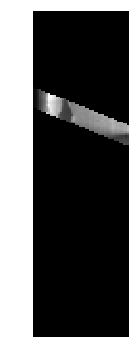

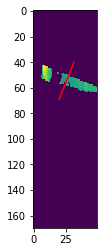

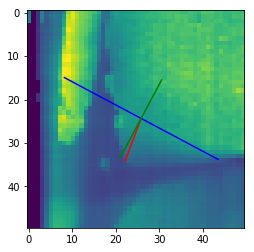

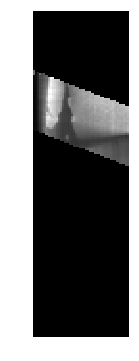

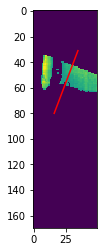

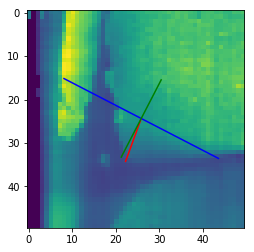

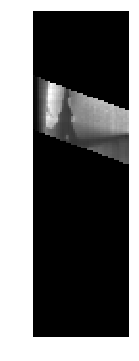

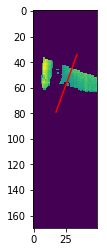

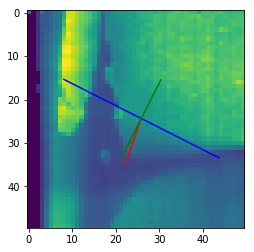

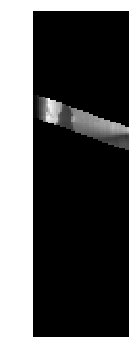

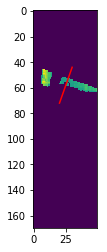

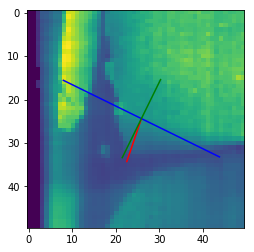

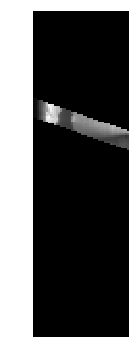

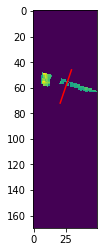

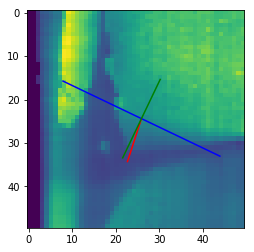

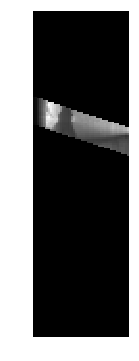

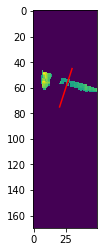

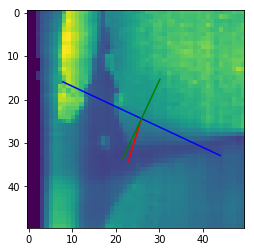

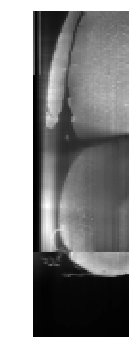

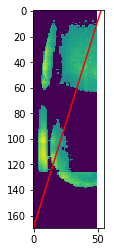

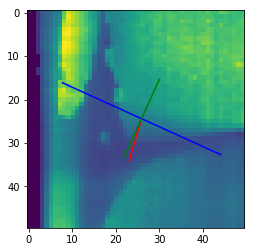

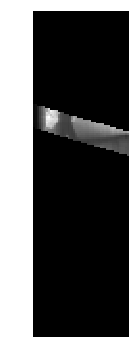

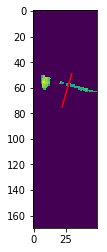

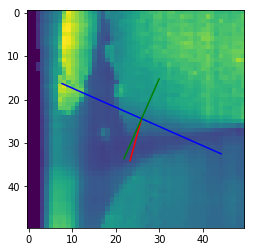

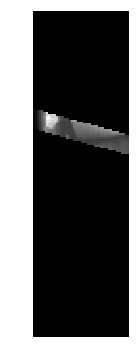

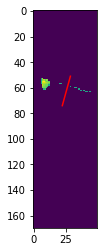

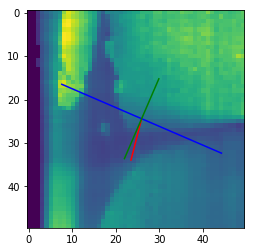

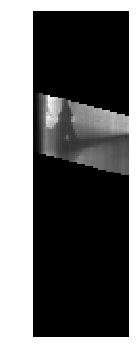

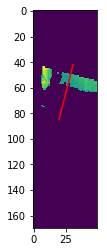

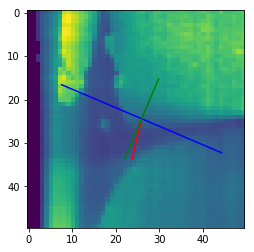

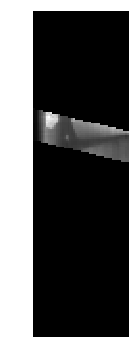

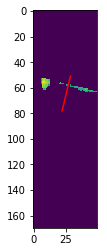

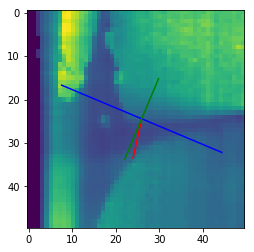

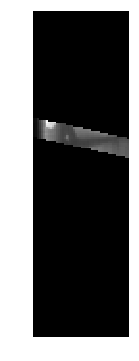

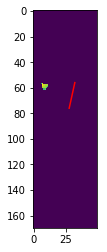

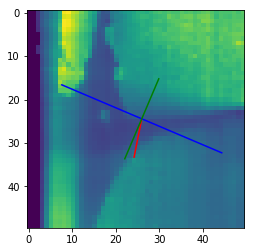

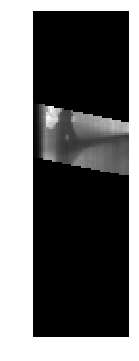

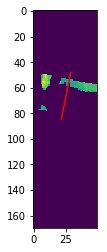

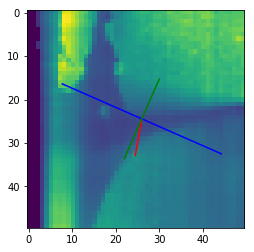

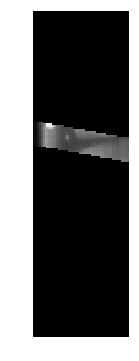

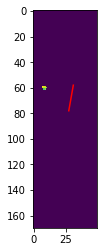

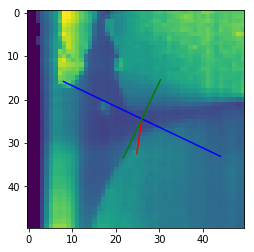

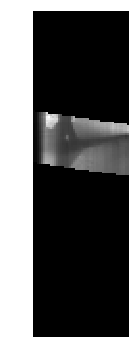

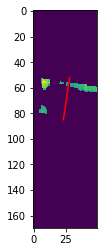

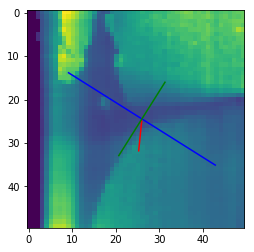

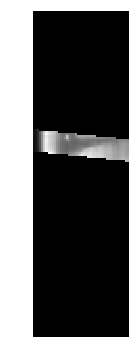

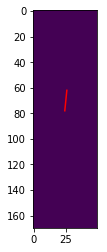

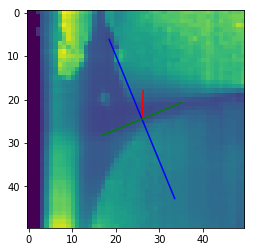

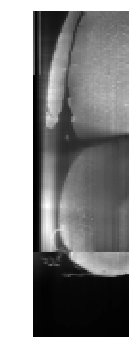

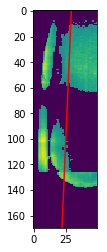

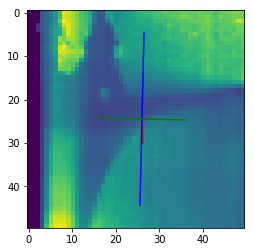

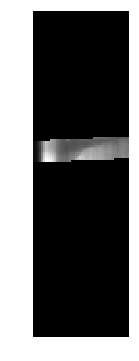

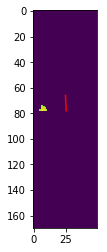

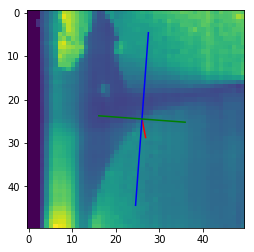

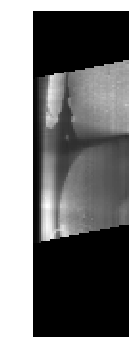

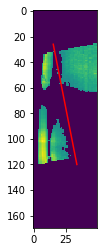

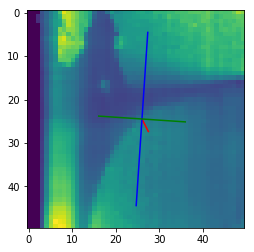

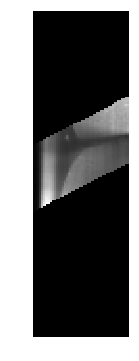

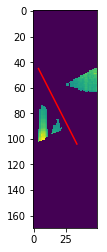

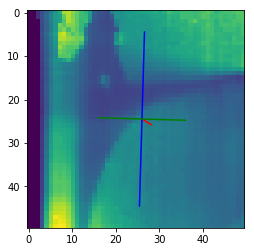

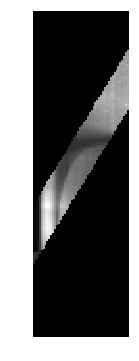

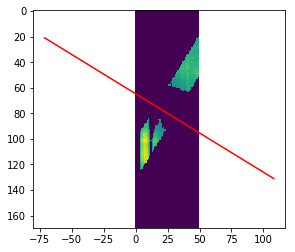

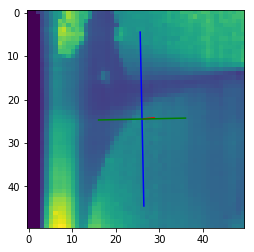

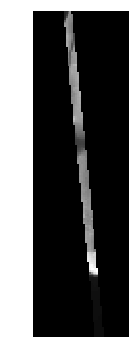

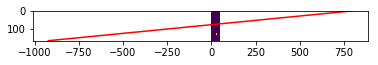

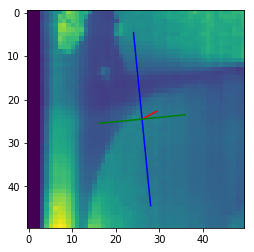

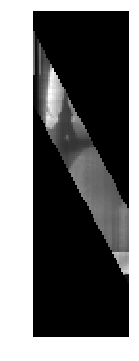

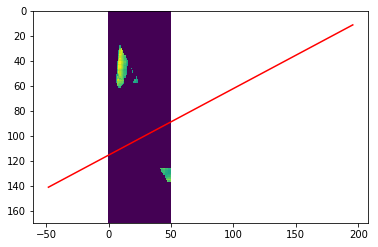

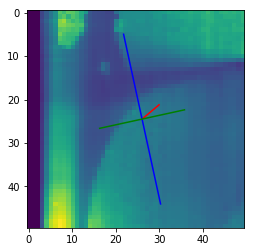

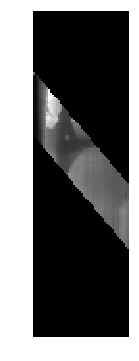

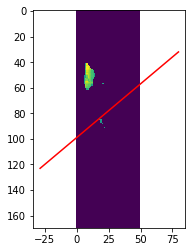

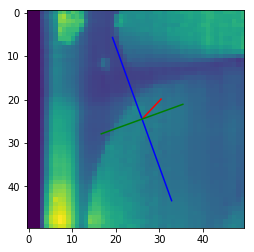

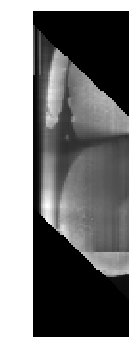

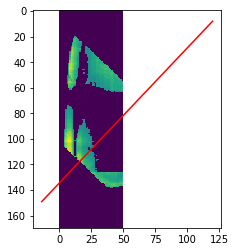

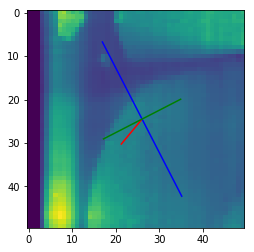

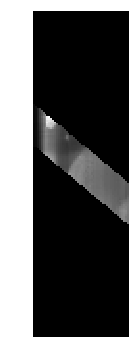

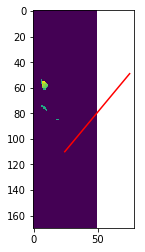

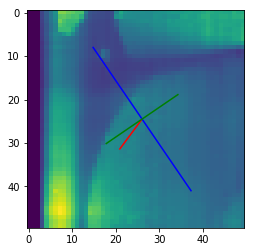

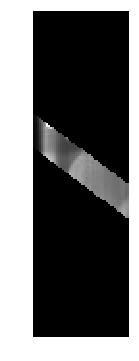

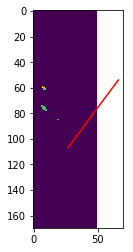

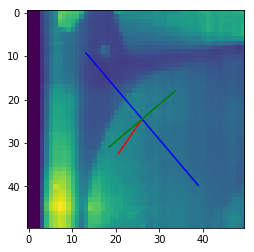

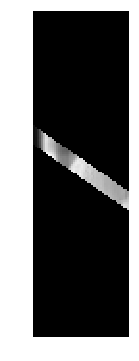

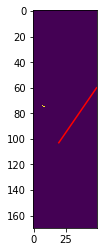

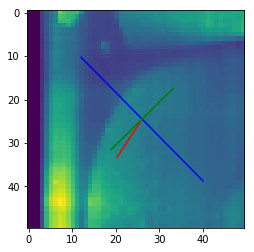

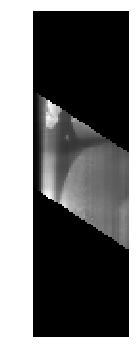

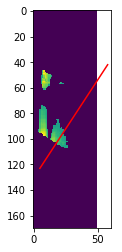

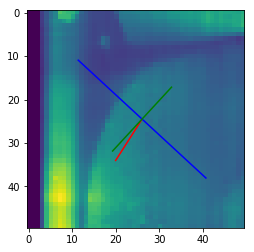

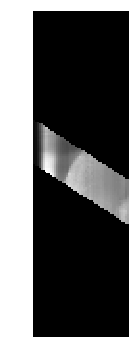

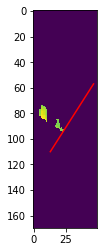

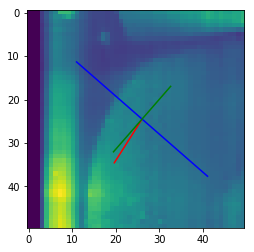

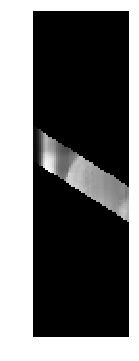

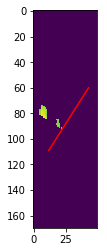

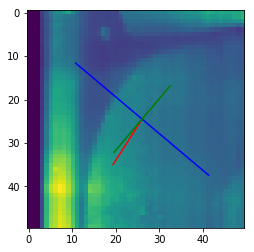

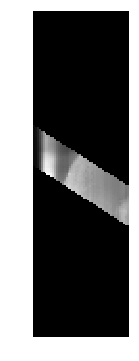

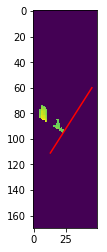

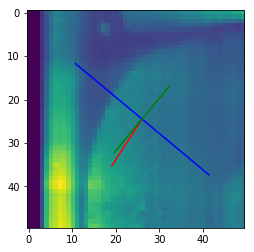

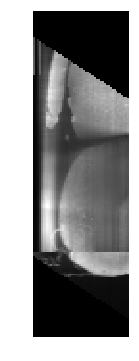

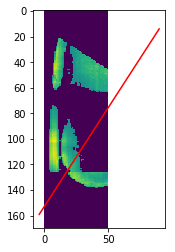

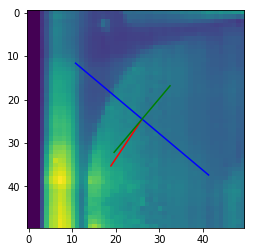

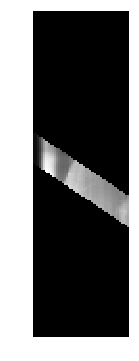

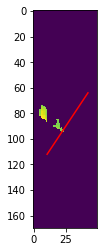

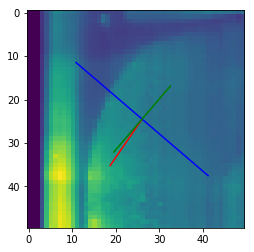

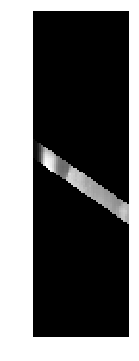

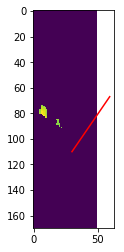

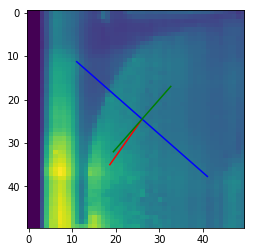

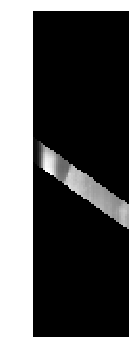

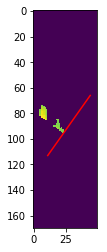

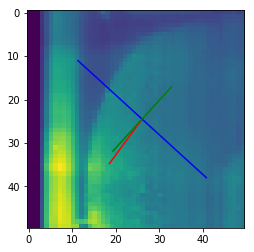

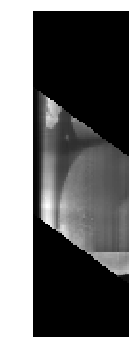

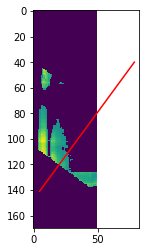

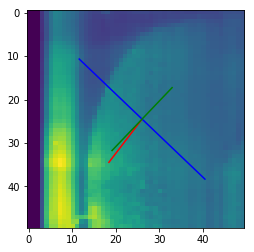

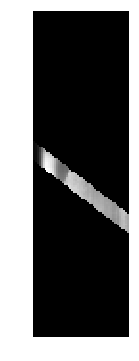

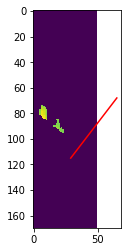

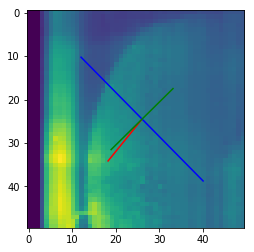

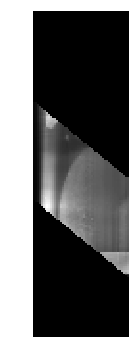

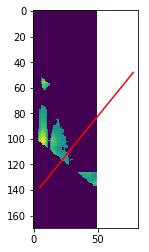

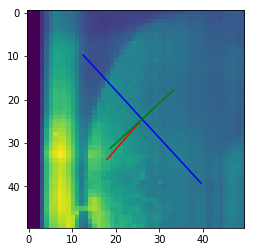

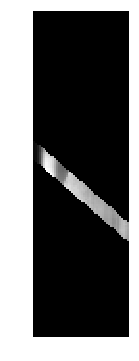

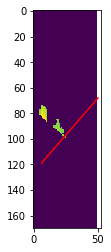

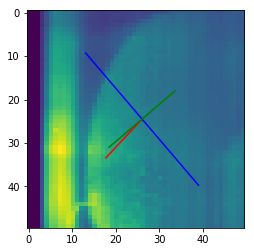

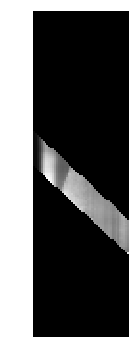

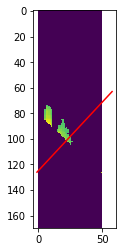

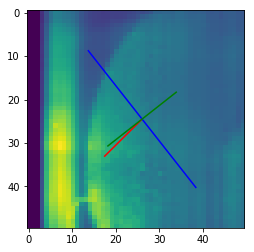

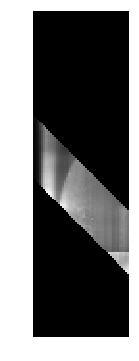

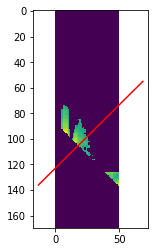

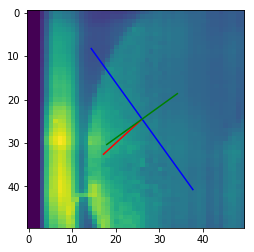

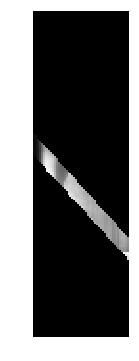

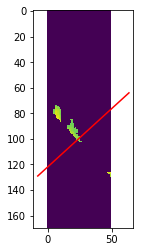

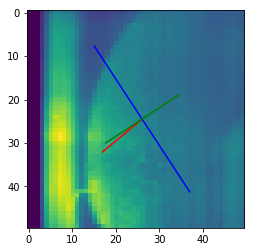

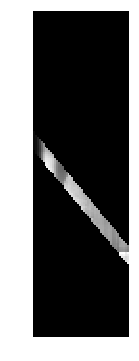

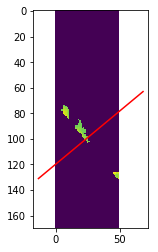

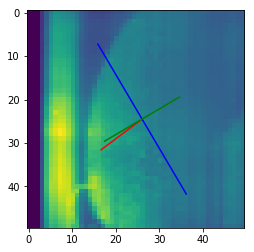

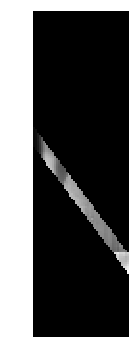

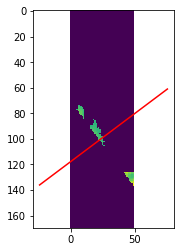

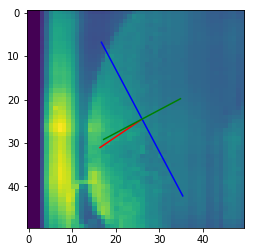

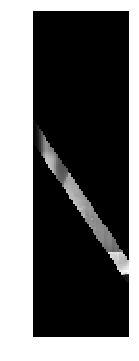

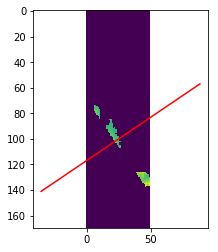

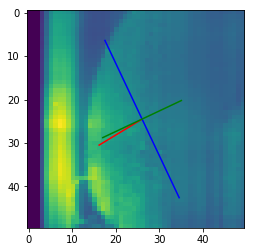

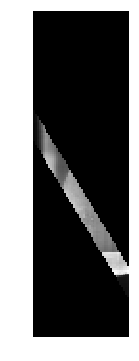

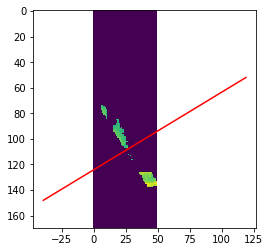

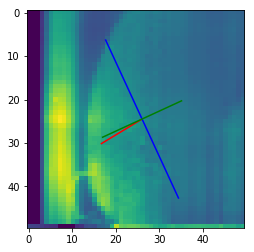

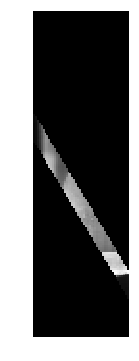

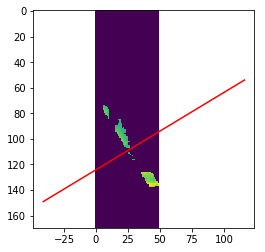

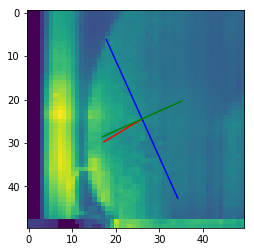

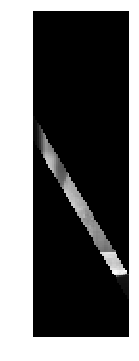

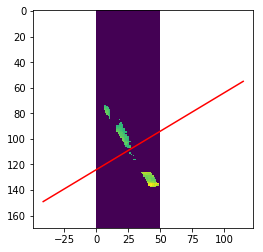

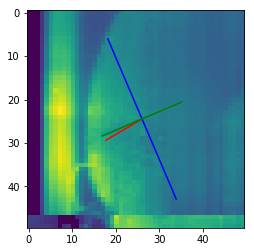

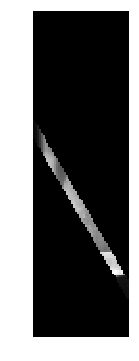

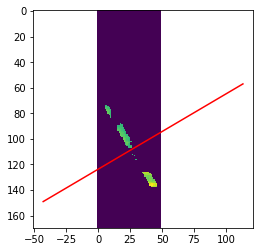

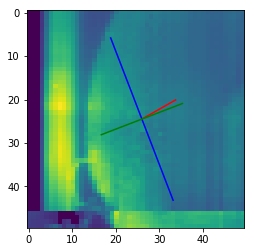

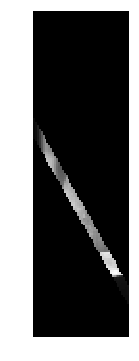

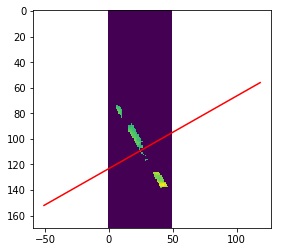

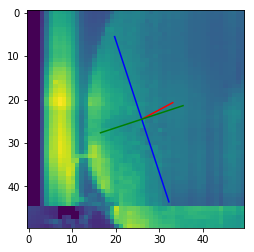

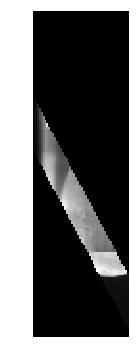

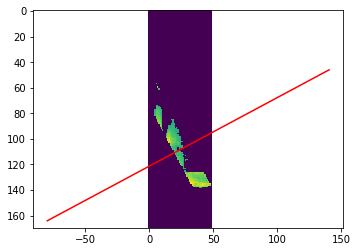

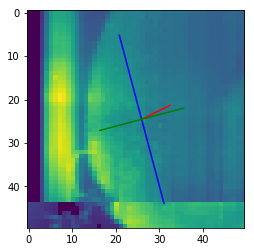

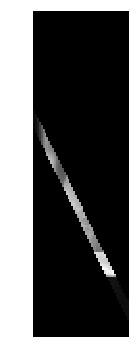

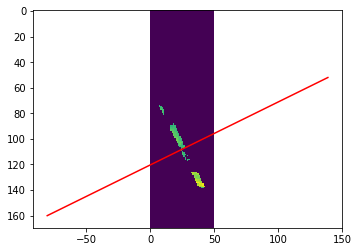

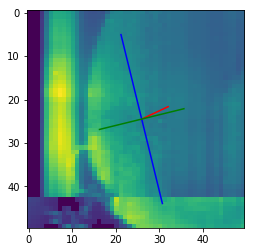

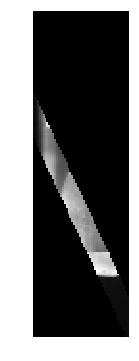

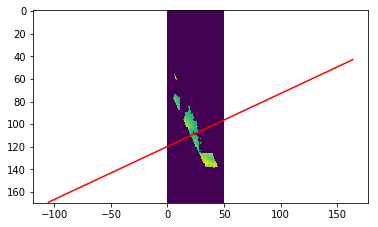

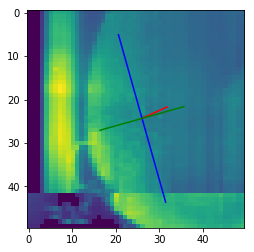

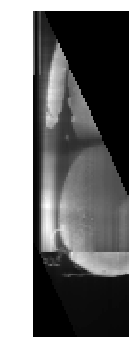

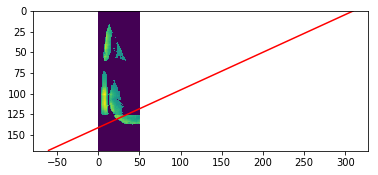

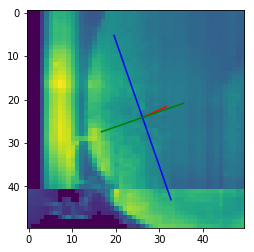

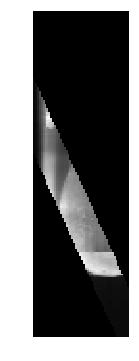

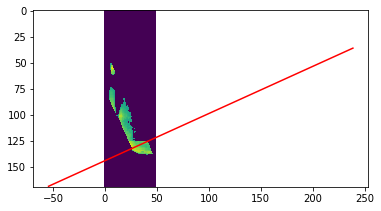

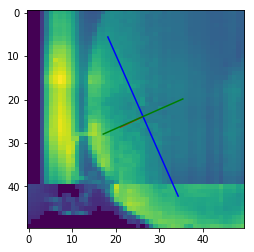

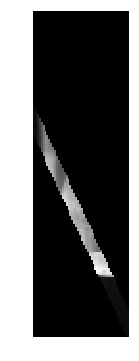

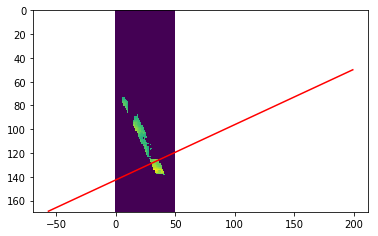

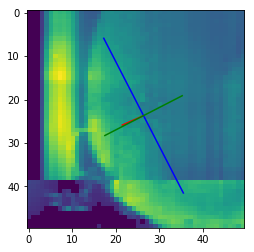

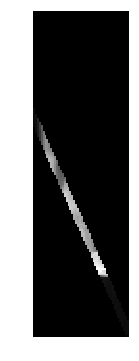

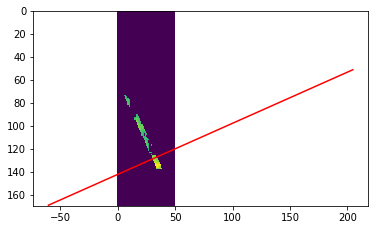

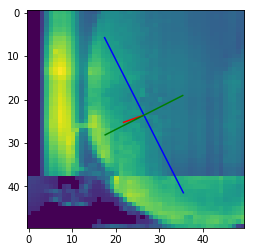

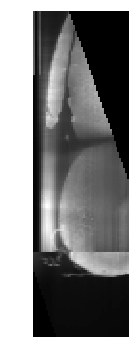

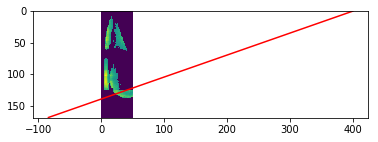

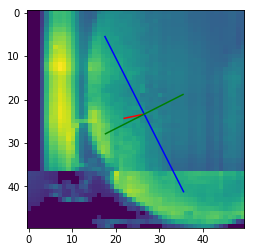

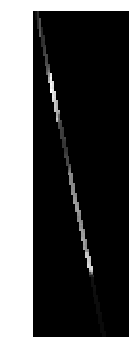

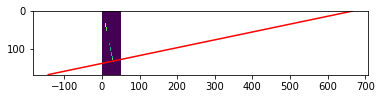

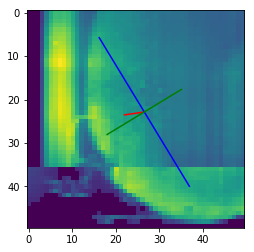

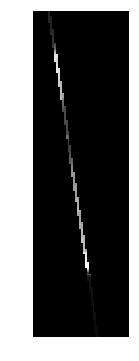

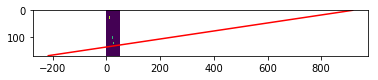

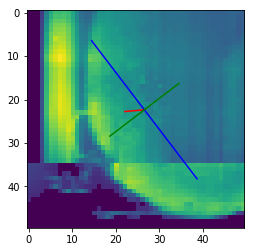

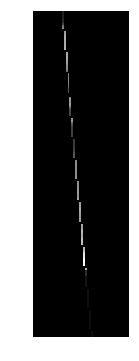

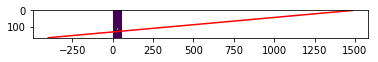

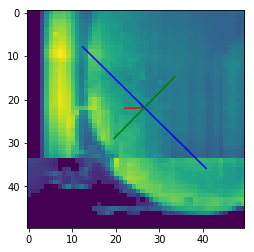

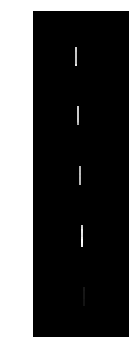

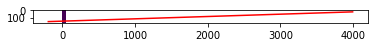

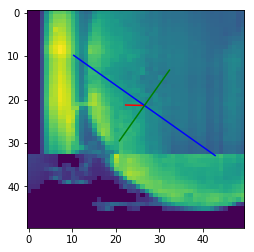

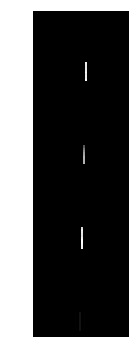

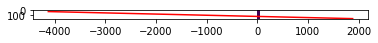

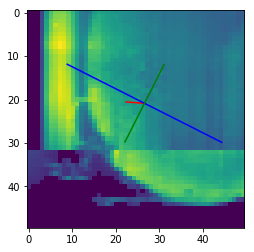

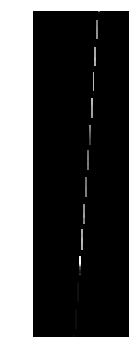

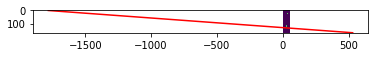

In [34]:
img = Image.from_array(cv.imread('0093.png')[:,:,0])
#img.rotate(7)
img.array = img.array[60:230,0:50]
img.show()
#cv.imwrite('roi.png',roi)

for y_m in tqdm(range(26, 170-50)):
    min_img = copy.deepcopy(img)
    min_img.array = min_img.array[y_m-25:y_m+25,:]
    min_img.plot_PCA_3D()
    epsilons = []
    img.vec = min_img.vec
    img.a = min_img.a
    x = img.get_slice(y_m=y_m)
    x.show()
    e = x.calc_devs_slice(epsilon_range=[0,30])
    #min_img.get_slice(y_m=y_m)
    epsilons.append(e)
#x.show()
#devs = []

    

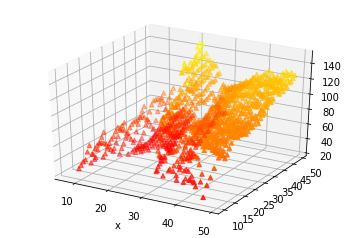

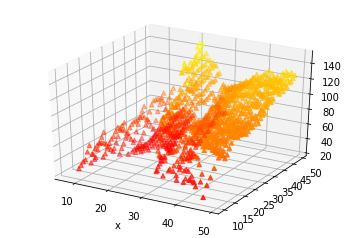

In [15]:
min_img.plot_3D()
#splottowac jakas powierzchnie tego,
#moze delikatnie wygladzic
# sprobowac gaussa albo sredniej wazonej

In [16]:
y,x, z = np.nonzero(min_img.arr_3D)
#mozna tez gaussy

#wyplotowac funkcje deva

In [20]:
sum_i_x = 0.0
sum_i_y = 0.0
z = z - 25.0
for i in range(y.shape[0]):
    sum_i_x += x[i] * z[i]
    sum_i_y += y[i] * z[i]

print(sum_i_x/np.sum(z))
print(sum_i_y/np.sum(z))


35.73419441518191
35.07293241118185


In [ ]:
mask = img.array < 25
img.array[mask] = 0
for y_m in tqdm(range(0, 170-50)):
    min_img = copy.deepcopy(img)
    min_img.array = min_img.array[y_m:y_m+50,:]
    min_img.plot_PCA_3D()

In [ ]:
x.__dict__.keys()

In [ ]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])

kernel_sharpening_x = np.array([[-1,0,-1], 
                              [-1, 9,-1],
                              [-1,0,-1]])

In [ ]:
img.__dict__.keys()

In [ ]:
%matplotlib widget
# aka import ipympl

In [ ]:
show(img_min>175)
img_min

### pocisnąć optymalizację parametru b

dla kazdej wartości b w jakims zakresie (np. 0,50).
policzyc
dla kazdego punktu P(x,y,z) takiego ze y > ax + b (dla a>=0)
                                    albo y < ax + b (dla a<0)

bierzemy punkt:
P'(x',y',z') taki ze wektor vec(P,P') = 2*vecP(P do ax+b)

mierzymy diff_z = (z'-z)**2

sumujemy diff_z

i robimy (diff_z)**(1/2)

i moze dzielimy to przez len(Ps) albo len(Ps**2).
albo mnozymy przez exp-(len(Ps)), nie wiem.
albo dzielimy przez ln(len(Ps))
jesli P' nie istnieje, to bierzemy z'=0 (sprobujmy)
i minimalizujemy to (zobaczymy jakie wyniki to da)

potem (druga godzina) sprawdzimy jak to robi ten program symmetry (te votes i w ogole) (optymalizacja paramteru r dla stalej theta)

In [ ]:
fig = show(img_min)

In [ ]:
#min_img.show()
mask = min_img.array < 25
min_img.array[mask] = 0
min_img.show()